In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import style
import seaborn as sns

from scipy.stats import poisson
from scipy.stats import gamma
from scipy.integrate import odeint

from tqdm import tqdm

from numpy import linalg as LA


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

In [206]:
df = pd.read_csv('First assignment March 2021\data_provinces.csv').drop('Unnamed: 0', axis = 1)
c_matrix = pd.read_csv('First assignment March 2021\italian_matrix.csv').drop('Unnamed: 0', axis = 1)

In [207]:
c_matrix = c_matrix.values
# Calclate the largest eigenvalue of contact maxtrix
s_r = max(LA.eigvals(c_matrix))

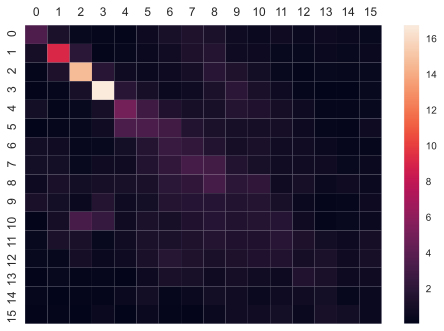

In [208]:
# isualizing contact matrix 
style.use('seaborn')

plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, \
                bottom=False, top = False, labeltop=True)
ax = sns.heatmap(c_matrix)

In [209]:
# Calculate age distribution in excell import result
n_df = pd.read_csv('First assignment March 2021\\age_structure.csv')
n = n_df["Sum of Total2"].values

In [210]:
def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) 
    return llkh

## Introducing demography to age-structured SIR

In [211]:
def SIR_demo(INPUT,t, n, m, BETA, g, l, death_per_group):    
    Y=np.zeros((16*3))
    S, I, R = np.hstack((INPUT[:16], 0)), np.hstack((INPUT[16:32], 0)), np.hstack((INPUT[32:], 0))
    N = S + I + R
    k= 16
    
    # Calculte birth vector -- only children can be born (obviously), therefore:
    birth = m*np.hstack((N.sum(), np.zeros(16)))
    
    for i in range(k):
        SUM = np.dot(BETA[i], I[:-1]/N[:-1]) *S[i]
        Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
        Y[(k+i)] = l[i]*I[i-1] + SUM - g*I[i] - l[i+1]*I[i] - death_per_group[i]*I[i] 
        Y[(2*k+i)] = l[i]*R[i-1] + g*I[i] - l[i+1]*R[i] - death_per_group[i]*R[i]
    return Y  

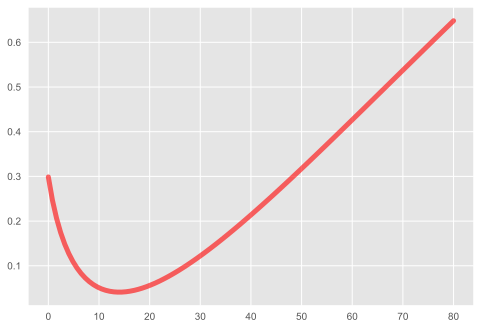

In [212]:
# Assuming the average death rate for all categories is unrealistic

# Other papers, both epidemiological and others, use gamma-life expectancy and binomial-life expectancy 
# this models have relatively high mortality for infants that goes to a minimum for 10-15 year olds 
# and steadily increases from there, this fits real world data (see references)

## Assuming a gamma distribution of death proabability

style.use('ggplot')

x = np.linspace(0,80, 100)
plt.plot(x, 3*(1-gamma.pdf(x, 18, loc = -3)**(1/170)),
       'r-', lw=5, alpha=0.6, label='gamma pdf')

## NB! This is obviously an approximation and ideally the curve would be fitted to data of mortality for Lombardy 
## but for the puposes of our model it is adequate 


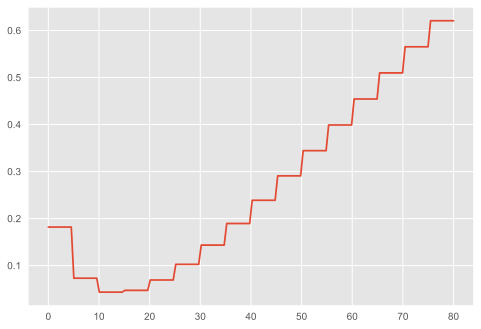

In [213]:
# Get average prob of death per age group
bucket_avg = []
for i in range(5,81,5):
    avg = np.array([3*(1-gamma.pdf(x, 18, loc = -3)**(1/170)) for x in np.linspace(i-5,i,100)]).sum()/100
    bucket_avg += [avg for i in np.linspace(i-5,i,10)]

plt.plot(np.linspace(0,80,len(bucket_avg)), bucket_avg )

In [214]:
# Now that we have the desired distribution of death rate by age
# we need to calibrate it in order to achieve a reasonable average death rate 

desired_d_rate = 1/(70*365) # How many people die ina day, given a life expectancy of 70? 
print("desired average death rate {}".format(desired_d_rate))

death_per_group = [np.array([0.00046213*(1-gamma.pdf(x, 30, loc = -10)**(1/150)) for x in np.linspace(i-5,i,100)]).sum()/100 for i in range(5,81,5)]

avg_death_rate = (death_per_group*n).sum()
avg_death_rate

desired average death rate 3.913894324853229e-05


3.9138327537992846e-05

In [259]:
# Define the rest of the parameters
T = 73 
steps_per_t = 1
t = np.arange(1, T+1, 1/steps_per_t) 

d = 14
m = avg_death_rate  # Keep population stabe by equating birth and date rates
l = np.hstack((0,np.ones(15)/(5*365),0)) 

# INITIALIZE POPULATION 
N = 80724

S0 = (N - 1) * n
I0 = np.zeros(16)
I0[3] = 1 # I assume first sick person is in the most active group 
R0 = np.array([0]*16)

INPUT = np.hstack((S0, I0, R0))

In [260]:
# Calibrate the model 
R0s = np.arange(1.5, 4, 0.001)

true_data = df['VA'][:72]

# Data store
I_hats = []
MSEs = []
llkhs = []

for R0 in tqdm(R0s):
    beta = R0/(d*s_r)
    BETA = beta*c_matrix
    g = 1/d

    # Run the model over time 
    RES = odeint(SIR_demo, INPUT ,t, args=(n, m, BETA, g, l, death_per_group))
    T_S, T_I_hat, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:].sum(axis=1)
    I_daily = (T_I_hat[1:]+T_R[1:])-(T_I_hat[:-1]+T_R[:-1])

    I_hats.append(I_daily)
    MSEs.append(np.sqrt(sum((I_daily-true_data)**2)/len(true_data)))
    llkhs.append(compute_loglikelihood(true_data,I_daily))
    
cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'llkh': llkhs, 'I_hat': I_hats})

best_model_MSE = cal.loc[cal['MSE'].idxmin()]
print('BEST MODEL MSE: RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
best_model_llkh = cal.loc[cal['llkh'].idxmax()]
print('BEST MODEL LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh['R0'], 4), best_model_llkh['llkh']))


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]<ipython-input-211-ffd604f24b57>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
<ipython-input-211-ffd604f24b57>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*I[i-1] + SUM - g*I[i] - l[i+1]*I[i] - death_per_group[i]*I[i]
  5%|████                                                                           | 129/2500 [00:05<01:48, 21.89it/s]


KeyboardInterrupt: 

<ipython-input-217-ef24157131a3>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


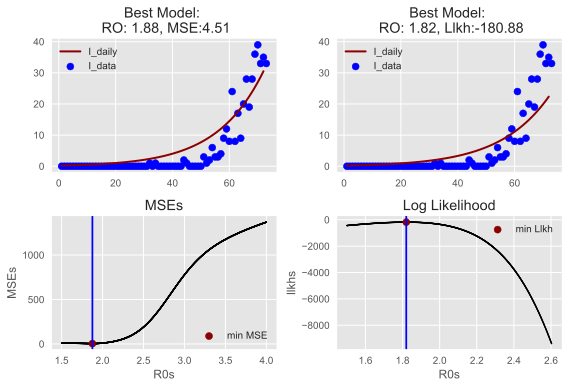

In [217]:
# Visualize results
fig, axs = plt.subplots(2,2, facecolor='w')
axs[0,0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
axs[0,0].scatter(t, df['VA'][:73], color = 'b', label = 'I_data')
axs[0,0].plot(t[:-1] ,best_model_MSE['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')

axs[0,1].set_title('Best Model: \n RO: {}, Llkh:{}'.format(round(best_model_llkh['R0'], 2), round(best_model_llkh['llkh'],2)))
axs[0,1].scatter(t, df['VA'][:73], color = 'b', label = 'I_data')
axs[0,1].plot(t[:-1] ,best_model_llkh['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')

axs[1,0].set_title('MSEs')
axs[1,0].scatter(cal['R0'], cal['MSE'], color = 'k' , s =1 )
axs[1,0].scatter(best_model_MSE['R0'], best_model_MSE['MSE'], color = 'darkred' , s =50, label='min MSE' )
axs[1,0].axvline(x= best_model_MSE['R0'], ymin=0, ymax=2, c= 'b')
axs[1,0].set_xlabel('R0s')
axs[1,0].set_ylabel('MSEs')
    
axs[1,1].set_title('Log Likelihood')
axs[1,1].scatter(cal['R0'], cal['llkh'], color = 'k' , s =1 )
axs[1,1].scatter(best_model_llkh['R0'], best_model_llkh['llkh'], color = 'darkred' , s =50, label='min Llkh' )
axs[1,1].axvline(x= best_model_llkh['R0'], ymin=0, ymax=2, c= 'b')
axs[1,1].set_xlabel('R0s')
axs[1,1].set_ylabel('llkhs')

for i in range(2):
    for z in range(2):
        axs[i,z].legend(fancybox = True)
        for spine in ('top', 'right'): 
            axs[i,z].spines[spine].set_visible(False)
        
fig.tight_layout()
fig.show()

## Introducing desease specific mortality

In [261]:
def SIR_mort(INPUT,t, n, m, BETA, g, l, death_per_group, mortality_by_group):    
    Y=np.zeros((16*3))
    S, I, R = np.hstack((INPUT[:16], 0)), np.hstack((INPUT[16:32], 0)), np.hstack((INPUT[32:], 0))
    N = S + I + R
    k= 16
    
    # Calculte birth vector -- only children can be born (obviously), therefore:
    birth = m*np.hstack((N.sum(), np.zeros(16)))
    
    for i in range(k):
        SUM = np.dot(BETA[i], I[:-1]/N[:-1]) *S[i]
        Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
        Y[(k+i)] = l[i]*I[i-1] + SUM - g*I[i] - l[i+1]*I[i] - death_per_group[i]*I[i] - mortality_by_group[i]*I[i]
        Y[(2*k+i)] = l[i]*R[i-1] + g*I[i] - l[i+1]*R[i] - death_per_group[i]*R[i]
    return Y  

In [262]:
# Despite introducing demographics the model still presents unnatural beahviour especially in the oldest group where 
# the population grows altough we know that they are a risk group for COVID 

# To reflec that we need to introduce desease mortality 
# The distribution of mortality by age is taken from the CDS 
reference_mortality = 0.000104
x = reference_mortality
mortality_by_group = [2*x, x, x, 10*x, 15*x, 15*x, 45*x, 45*x, 130*x, 130*x, 400*x, 400*x, 400*x, 1100*x, 1100*x, 5500*x]

# Now we need to calculate the average mortality and calibrate the reference mortality such that we reflect the data 
distr = np.dot(c_matrix,n)/np.dot(c_matrix,n).sum() # Assuming equal transition rate (reference) we can approximate the distribution in this way
avg_mortality = (mortality_by_group*distr).sum()

#total_mortaity according to latest Italy stats - COVID related
desired_mortality = 0.0378

print('Desired: {} ; Average: {}'.format(desired_mortality, avg_mortality))

Desired: 0.0378 ; Average: 0.037790000738072836


In [263]:
# Redefine the required parameters
S0 = (N - 1) * n
I0 = np.zeros(16)
I0[3] = 1 # I assume first sick person is in the most active group 
R0 = np.array([0]*16)

INPUT = np.hstack((S0, I0, R0))

In [264]:
# Calibrate the model 
R0s = np.arange(1.5, 4, 0.001)

true_data = df['VA'][:72]

# Data store
I_hats = []
MSEs = []
llkhs = []

for R0 in tqdm(R0s):
    beta = R0/(d*s_r)
    BETA = beta*c_matrix
    g = 1/d

    # Run the model over time 
    RES = odeint(SIR_mort, INPUT ,t, args=(n, m, BETA, g, l, death_per_group, mortality_by_group))
    T_S, T_I_hat, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:].sum(axis=1)
    I_daily = (T_I_hat[1:]+T_R[1:])-(T_I_hat[:-1]+T_R[:-1])

    I_hats.append(I_daily)
    MSEs.append(np.sqrt(sum((I_daily-true_data)**2)/len(true_data)))
    llkhs.append(compute_loglikelihood(true_data,I_daily))
    
cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'llkh': llkhs, 'I_hat': I_hats})

best_model_MSE = cal.loc[cal['MSE'].idxmin()]
print('BEST MODEL MSE: RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
best_model_llkh = cal.loc[cal['llkh'].idxmax()]
print('BEST MODEL LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh['R0'], 4), best_model_llkh['llkh']))

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]<ipython-input-261-8b76ab430f37>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
<ipython-input-261-8b76ab430f37>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*I[i-1] + SUM - g*I[i] - l[i+1]*I[i] - death_per_group[i]*I[i] - mortality_by_group[i]*I[i]
 50%|███████████████████████████████████████▏                                      | 1256/2500 [02:06<02:15,  9.21it/s]<ipython-input-210-51716027bac9>:4: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i]))
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:42<00:00,  8.85it/s]

BEST MODEL MSE: RO: 1.97, MSE:4.48
BEST MODEL LogLike: RO: 1.917, llkh:-179.38183984476808


In [267]:
# Visualzing the model using calibrated R0

T = 500 # Period used for data visualization
steps_per_t = 1 # We assume one step is quivalent to one day 
t = np.arange(1, T+1, 1/steps_per_t) 

C_R0 = best_model_MSE['R0']
beta = R0/(d*s_r)
BETA = beta*c_matrix
g = 1/d

RES = odeint(SIR_mort, INPUT ,t, args=(n, m, BETA, g, l, death_per_group, mortality_by_group))

<ipython-input-261-8b76ab430f37>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
<ipython-input-261-8b76ab430f37>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*I[i-1] + SUM - g*I[i] - l[i+1]*I[i] - death_per_group[i]*I[i] - mortality_by_group[i]*I[i]


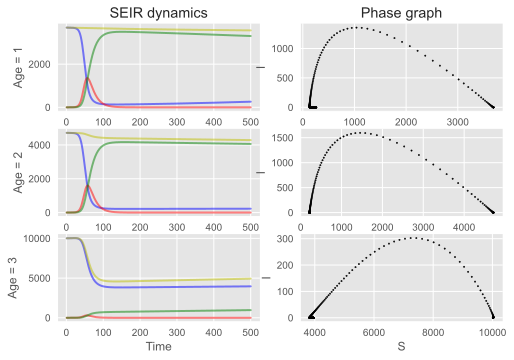

In [268]:
# Comparing the spread of COVID accross age groups 

# As we can see from the graphs the introduction of demographics and desease mortality reflect the risk to old people and show a worst case scenario with no government interventions
# Although a lower number of people get infected due to less social contact, COVID is very seveare in the 75+ category leading to a lot of fatalities

S_y, I_y, R_y = RES[:,1], RES[:,17], RES[:,33]
S_m, I_m, R_m = RES[:,7], RES[:,23], RES[:,39]
S_o, I_o, R_o = RES[:,15], RES[:,31], RES[:,47]

S = np.hstack((S_y, S_m, S_o)).reshape(3,-1)
I = np.hstack((I_y, I_m, I_o)).reshape(3,-1)
R = np.hstack((R_y, R_m, R_o)).reshape(3,-1)

fig, ax = plt.subplots(3,2, facecolor='w')

for i in range(3):        
    ax[0,0].set_title('SEIR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R)[i,:], 'y', alpha=0.5, lw=2)

    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('Age = {}'.format(i+1))

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[i,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

## Finally as we saw in ex. 1  SEIR is more appropriate for COVID so that is the last improvement we add before exploring how interventions affect the model

In [269]:
def SEIR_eq(INPUT,t, n, m, BETA, g, l, death_per_group, mortality_by_group, omega):    
    Y=np.zeros((16*4))
    S, E, I, R = np.hstack((INPUT[:16], 0)), np.hstack((INPUT[16:32], 0)), np.hstack((INPUT[32:48], 0)), np.hstack((INPUT[48:], 0)) # add zero at the end so that the maturity works 
    N = S + E + I + R
    k= 16
    
    birth = m*np.hstack((N.sum(), np.zeros(16)))
    
    for i in range(k):
        SUM = np.dot(BETA[i], I[:-1]/N[:-1]) *S[i]
        Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
        Y[(k+i)] = l[i]*E[i-1] + SUM - (omega + l[i+1] + death_per_group[i])*E[i] 
        Y[(2*k+i)] = l[i]*I[i-1] + omega*E[i] - (g + l[i+1] + death_per_group[i] + mortality_by_group[i])*I[i] 
        Y[(3*k+i)] = l[i]*R[i-1] + g*I[i] - (l[i+1] + death_per_group[i])*R[i]
    return Y  

In [270]:
# Define parameters
inc = 5 # we assume an incubation period of 5 days in accordance with the literature 
omega = 1/inc

S0 = (N - 1) * n
I0 = np.zeros(16)
I0[3] = 1 # I assume first sick person is in the most active group 
E0 = np.array([0]*16)
R0 = np.array([0]*16)

INPUT = np.hstack((S0, E0, I0, R0))

# Calibrate the model
T = 73 
steps_per_t = 1
t = np.arange(1, T+1, 1/steps_per_t) 

R0s = np.arange(2.5, 3, 0.001)

true_data = df['VA'][:72]

# Data store
I_hats = []
MSEs = []
llkhs = []

for R0 in tqdm(R0s):
    beta = R0/(d*s_r)
    BETA = beta*c_matrix
    g = 1/d

    # Run the model over time 
    RES = odeint(SEIR_eq, INPUT ,t, args=(n, m, BETA, g, l, death_per_group, mortality_by_group, omega))
    T_S, T_E, T_I_hat, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:48].sum(axis=1), RES[:,48:].sum(axis=1)
    I_daily = (T_I_hat[1:]+T_R[1:])-(T_I_hat[:-1]+T_R[:-1])

    I_hats.append(I_daily)
    MSEs.append(np.sqrt(sum((I_daily-true_data)**2)/len(true_data)))
    llkhs.append(compute_loglikelihood(true_data,I_daily))
    
cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'llkh': llkhs, 'I_hat': I_hats})

best_model_MSE = cal.loc[cal['MSE'].idxmin()]
print('BEST MODEL MSE: RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
best_model_llkh = cal.loc[cal['llkh'].idxmax()]
print('BEST MODEL LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh['R0'], 4), best_model_llkh['llkh']))

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]<ipython-input-269-4558a7b40ef2>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
<ipython-input-269-4558a7b40ef2>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*E[i-1] + SUM - (omega + l[i+1] + death_per_group[i])*E[i]
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:51<00:00,  9.77it/s]

BEST MODEL MSE: RO: 2.79, MSE:4.02
BEST MODEL LogLike: RO: 2.687, llkh:-157.18738010498726


In [274]:
# Visualzing the model using calibrated R0

T = 500 # Period used for data visualization
steps_per_t = 1 # We assume one step is quivalent to one day 
t = np.arange(1, T+1, 1/steps_per_t) 

C_R0 = best_model_MSE['R0']
beta = R0/(d*s_r)
BETA = beta*c_matrix
g = 1/d

RES = odeint(SEIR_eq, INPUT ,t, args=(n, m, BETA, g, l, death_per_group, mortality_by_group, omega))

<ipython-input-269-4558a7b40ef2>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
<ipython-input-269-4558a7b40ef2>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[(k+i)] = l[i]*E[i-1] + SUM - (omega + l[i+1] + death_per_group[i])*E[i]


2.7879999999999683

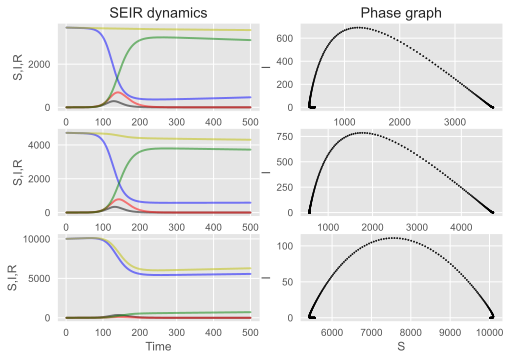

In [273]:
# Comparing the spread of COVID accross age groups 

# Not super sure here, exposed state seems to show that the virus is worse than expected but why? In my mind the exposed state doesn't realy do much idk 
# It should change R0, why does it??

# The exposed state acts as a delayer, therefore to fit the dynamics we have with this delayed model we need higher R0, thats the logic 

S_y, E_y, I_y, R_y = RES[:,1], RES[:,17], RES[:,33], RES[:,49]
S_m, E_m, I_m, R_m = RES[:,7], RES[:,23], RES[:,39], RES[:,55]
S_o, E_o, I_o, R_o = RES[:,15], RES[:,31], RES[:,47], RES[:,63]

S = np.hstack((S_y, S_m, S_o)).reshape(3,-1)
E = np.hstack((E_y, E_m, E_o)).reshape(3,-1)
I = np.hstack((I_y, I_m, I_o)).reshape(3,-1)
R = np.hstack((R_y, R_m, R_o)).reshape(3,-1)

fig, ax = plt.subplots(3,2, facecolor='w')

for i in range(3):        
    ax[0,0].set_title('SEIR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, E[i,:], 'black', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R + E)[i,:], 'y', alpha=0.5, lw=2)

    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('S,I,R')

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[i,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

# Exploring effects of Lockdown and Quarantining 

## Lockdown 

In order to implement lockdown we  will intoduce a time varying beta
our assumption is that beat represents the inherent transmisibility of COVID
therefore that number won't be affected by lockdown, but by scalling down beta
we effectively scale down the values in our contact matrix, in a sense saying that 
lockdown redces the number of contacts and therefore the total transmissibility

 We explore two approaches:
 * 1. A flat 50% reduction in contacts representing the lockdown implemented on the 8th of march 
 * 2. A gradual adoption of the lockdown measures more true to the real dynamics 

In [275]:
# 1st Approach 
def l_beta1(t, R0):
    if t <= 36:
        beta = R0/(d*s_r)
    else:
        beta = (R0/(d*s_r))*0.5
    return float(beta)

The second approach implements a inverse exponential fucntion e^-wt which models the measures 
reception by the public, in this function we assume that people need a month in the beggining 
to truly appreciate the severity of the desease and restrict their contacts 

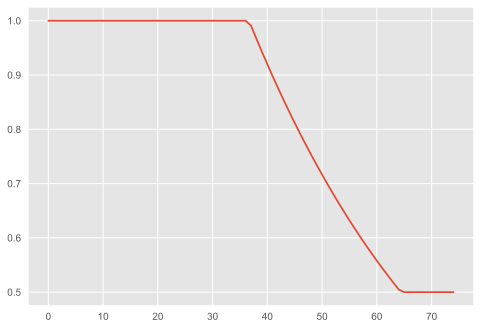

In [276]:
# 2nd Approach
def l_beta2(t, R0):
    if t <= 36:
        beta = R0/(d*s_r)
    else:
        beta = (R0/(d*s_r))*max(3*np.exp(-0.03*t),0.5)
    return float(beta)

# The gradual adoption of lockdown measures
plt.plot(np.arange(75), [1 if t <= 36 else max(2.5*np.exp(-0.025*t), 0.5) for t in np.arange(75)])


In [277]:
# Defining SEIR with lockdown 
def SEIR_ld(INPUT,t, n, m, l_beta, g, l, death_per_group, mortality_by_group, omega, R0):
    
    BETA = l_beta(t, R0)*c_matrix
    
    Y=np.zeros((16*4))
    S, E, I, R = np.hstack((INPUT[:16], 0)), np.hstack((INPUT[16:32], 0)), np.hstack((INPUT[32:48], 0)), np.hstack((INPUT[48:], 0)) # add zero at the end so that the maturity works 
    N = S + E + I + R
    k= 16
    
    birth = m*np.hstack((N.sum(), np.zeros(16)))
    
    for i in range(k):
        SUM = np.dot(BETA[i], I[:-1]/N[:-1]) *S[i]
        Y[i] = birth[i] + l[i]*S[i-1] - SUM - l[i+1]*S[i] - death_per_group[i]*S[i]
        Y[(k+i)] = l[i]*E[i-1] + SUM - (omega + l[i+1] + death_per_group[i])*E[i] 
        Y[(2*k+i)] = l[i]*I[i-1] + omega*E[i] - (g + l[i+1] + death_per_group[i] + mortality_by_group[i])*I[i] 
        Y[(3*k+i)] = l[i]*R[i-1] + g*I[i] - (l[i+1] + death_per_group[i])*R[i]
    return Y 

In [307]:
# Defining parameters 
inc = 5 # we assume an incubation period of 5 days in accordance with the literature 
omega = 1/inc

S0 = (N - 1) * n
I0 = np.zeros(16)
I0[3] = 1 # I assume first sick person is in the most active group 
E0 = np.array([0]*16)
R0 = np.array([0]*16)

INPUT = np.hstack((S0, E0, I0, R0))

# Calibrate the both models to compare
T = 73 
steps_per_t = 1
t = np.arange(1, T+1, 1/steps_per_t) 

R0s = np.arange(3, 4, 0.001)

true_data = df['VA'][:72]

# Data store
I_hats_1 = []
I_hats_2 = []
MSEs_1 = []
llkhs_1 = []
MSEs_2= []
llkhs_2 = []

for R0 in tqdm(R0s):
    g = 1/d

    # Run the model 1
    RES = odeint(SEIR_ld, INPUT ,t, args=(n, m, l_beta1, g, l, death_per_group, mortality_by_group, omega, R0))
    T_S, T_E, T_I_hat, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:48].sum(axis=1), RES[:,48:].sum(axis=1)
    I_daily_1 = (T_I_hat[1:]+T_R[1:])-(T_I_hat[:-1]+T_R[:-1])
    I_hats_1.append(I_daily_1)
    
    MSEs_1.append(np.sqrt(sum((I_daily_1-true_data)**2)/len(true_data)))
    llkhs_1.append(compute_loglikelihood(true_data,I_daily_1))
    
    # Run the model 2
    RES = odeint(SEIR_ld, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, R0))
    T_S, T_E, T_I_hat, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:48].sum(axis=1), RES[:,48:].sum(axis=1)
    I_daily_2 = (T_I_hat[1:]+T_R[1:])-(T_I_hat[:-1]+T_R[:-1])
    I_hats_2.append(I_daily_2)
    
    MSEs_2.append(np.sqrt(sum((I_daily_2-true_data)**2)/len(true_data)))
    llkhs_2.append(compute_loglikelihood(true_data,I_daily_2))
    
cal_1 = pd.DataFrame({'R0': R0s, 'MSE': MSEs_1, 'llkh': llkhs_1, 'I_hat': I_hats_1})
cal_2 = pd.DataFrame({'R0': R0s, 'MSE': MSEs_2, 'llkh': llkhs_2, 'I_hat': I_hats_2})

best_model_MSE_ld1 = cal_1.loc[cal_1['MSE'].idxmin()]
print('BEST MODEL_1 MSE: RO: {}, MSE:{}'.format(round(best_model_MSE_ld1['R0'], 2), round(best_model_MSE_ld1['MSE'],2)))
best_model_llkh_ld1 = cal_1.loc[cal_1['llkh'].idxmax()]
print('BEST MODEL_1 LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh_ld1['R0'], 4), best_model_llkh_ld1['llkh']))
best_model_MSE_ld2 = cal_2.loc[cal_2['MSE'].idxmin()]
print('BEST MODEL_2 MSE: RO: {}, MSE:{}'.format(round(best_model_MSE_ld2['R0'], 2), round(best_model_MSE_ld2['MSE'],2)))
best_model_llkh_ld2 = cal_2.loc[cal_2['llkh'].idxmax()]
print('BEST MODEL_2 LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh_ld2['R0'], 4), best_model_llkh_ld2['llkh']))

  0%|                                                                                          | 0/701 [00:00<?, ?it/s]<ipython-input-275-434a745cfa50>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(beta)
100%|████████████████████████████████████████████████████████████████████████████████| 701/701 [02:46<00:00,  4.21it/s]

BEST MODEL_1 MSE: RO: 3.71, MSE:6.62
BEST MODEL_1 LogLike: RO: 3.511, llkh:-269.2208929322738
BEST MODEL_2 MSE: RO: 3.31, MSE:7.05
BEST MODEL_2 LogLike: RO: 3.3, llkh:-281.1888336401486


In [305]:
# As expected the calibrated R0 under immediate lockdown scenario is higher, this is because we assume that the lockdown measure is perfectly successful 
# and therefore fitting the data leads us to believe that the vrus is more aggressive, as mentioned before this scenario might not be the most reaslistic 

In [306]:
T = 500 # Period used for data visualization
steps_per_t = 1 # We assume one step is quivalent to one day 
t = np.arange(1, T+1, 1/steps_per_t) 

C_R0_1 = best_model_MSE_ld1['R0']
C_R0_2 = best_model_MSE_ld2['R0']

g = 1/d
omega = 1/inc

RES1 = odeint(SEIR_ld, INPUT ,t, args=(n, m, l_beta1, g, l, death_per_group, mortality_by_group, omega, C_R0_1))
RES2 = odeint(SEIR_ld, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, C_R0_2))

<ipython-input-275-434a745cfa50>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(beta)


In [ ]:
# In the graphs below we can compare the spreead of the desese over time under both lockdown scenarios

# As you can see although both models were fitted to the same intital data, model two peaks at a higher number of infected individuals 
S_1, E_1, I_1, R_1 = RES1[:,:16].sum(axis=1), RES1[:,16:32].sum(axis=1), RES1[:,32:48].sum(axis=1), RES1[:,48:].sum(axis=1)
S_2, E_2, I_2, R_2 = RES2[:,:16].sum(axis=1), RES2[:,16:32].sum(axis=1), RES2[:,32:48].sum(axis=1), RES2[:,48:].sum(axis=1)

S = np.hstack((S_1, S_2)).reshape(2,-1)
E = np.hstack((E_1, E_2)).reshape(2,-1)
I = np.hstack((I_1, I_2)).reshape(2,-1)
R = np.hstack((R_1, R_2)).reshape(2,-1)

fig, ax = plt.subplots(2,2, facecolor='w')

for i in range(2):        
    ax[0,0].set_title('SEIR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, E[i,:], 'black', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R + E)[i,:], 'y', alpha=0.5, lw=2)

    ax[1,0].set_xlabel('Time')
    ax[i,0].set_ylabel('MODEL_{}'.format(i+1))

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[1,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

<ipython-input-275-434a745cfa50>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(beta)


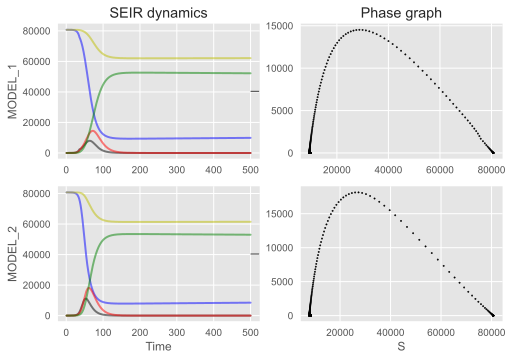

In [282]:
# In this graph we compare two models with the same R0 to better see the difference in the two lockdown approaches 

# Even in this lockdown that was impleneted quite fast we can see that under scenario one we have a flatter and lower curve 
# compared to scenario 2
C_R0_1 = 8
C_R0_2 = 8

RES1 = odeint(SEIR_ld, INPUT ,t, args=(n, m, l_beta1, g, l, death_per_group, mortality_by_group, omega, C_R0_1))
RES2 = odeint(SEIR_ld, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, C_R0_2))

S_1, E_1, I_1, R_1 = RES1[:,:16].sum(axis=1), RES1[:,16:32].sum(axis=1), RES1[:,32:48].sum(axis=1), RES1[:,48:].sum(axis=1)
S_2, E_2, I_2, R_2 = RES2[:,:16].sum(axis=1), RES2[:,16:32].sum(axis=1), RES2[:,32:48].sum(axis=1), RES2[:,48:].sum(axis=1)

S = np.hstack((S_1, S_2)).reshape(2,-1)
E = np.hstack((E_1, E_2)).reshape(2,-1)
I = np.hstack((I_1, I_2)).reshape(2,-1)
R = np.hstack((R_1, R_2)).reshape(2,-1)

fig, ax = plt.subplots(2,2, facecolor='w')

for i in range(2):        
    ax[0,0].set_title('SEIR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, E[i,:], 'black', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R + E)[i,:], 'y', alpha=0.5, lw=2)

    ax[1,0].set_xlabel('Time')
    ax[i,0].set_ylabel('MODEL_{}'.format(i+1))

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[1,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

## Now we add the second measure - Quarantine!

Now the final measure we wanted to check out is how quarantine affects the spread and the estimamted R0
we do this by implementing a Q state = SEIQR, which reflects that some infected people are 
detected and isolated 

In [294]:
# Defining the model 
q = 0.04 # Assume that each day 4 percent of Exposed individuals get quranntined due to random testing

def SEIQR_eq(INPUT, t, n, m, l_beta, g, l, death_per_group, mortality_by_group, omega, R0, q):
    
    BETA = l_beta(t, R0)*c_matrix
    
    Y=np.zeros((16*5))
    S, E, I, Q, R = np.hstack((INPUT[:16], 0)), np.hstack((INPUT[16:32], 0)), np.hstack((INPUT[32:48], 0)), np.hstack((INPUT[48:64], 0)), np.hstack((INPUT[64:], 0)) # add zero at the end so that the maturity works 
    N = S + E + I + Q + R
    k= 16
    
    birth =  m*np.hstack((N.sum(), np.zeros(16)))
    
    for i in range(k):
        SUM = np.dot(BETA[i], I[:-1]/N[:-1]) *S[i]
        Y[i] = birth[i] + l[i]*S[i-1] - SUM - (l[i+1] + death_per_group[i])*S[i]
        Y[(k+i)] = l[i]*E[i-1] + SUM - (omega + l[i+1] + death_per_group[i])*E[i]
        Y[(2*k+i)] = l[i]*I[i-1] + omega*E[i] - (g + q + l[i+1] + death_per_group[i] + mortality_by_group[i])*I[i]
        Y[(3*k+i)] = l[i]*Q[i-1] + q*I[i] - (g + l[i+1] + death_per_group[i] + mortality_by_group[i])*Q[i]
        Y[(4*k+i)] = l[i]*R[i-1] + g*(I[i] + Q[i]) - (l[i+1] + death_per_group[i])*R[i]
    return Y 

In [296]:
SEIQR_eq
# Defining parameters 
inc = 5 # we assume an incubation period of 5 days in accordance with the literature 
omega = 1/inc
g = 1/d

S0 = (N - 1) * n
I0 = np.zeros(16)
I0[3] = 1 # I assume first sick person is in the most active group 
E0 = np.array([0]*16)
Q0 = np.array([0]*16)
R0 = np.array([0]*16)

INPUT = np.hstack((S0, E0, I0, Q0, R0))

# Calibrate the both models to compare
T = 73 
steps_per_t = 1
t = np.arange(1, T+1, 1/steps_per_t) 

R0s = np.arange(3.7, 4.5, 0.001)

true_data = df['VA'][:72]

# Data store
I_hats_1 = []
MSEs_1 = []
llkhs_1 = []

for R0 in tqdm(R0s):
    
    # Run the model 1
    RES = odeint(SEIQR_eq, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, R0, q)) # I am using lockdown under second approach
    T_S, T_E, T_I_hat, T_Q, T_R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:48].sum(axis=1), RES[:,48:64].sum(axis=1), RES[:,64:].sum(axis=1)
    I_daily_1 = (T_I_hat[1:]+T_R[1:] + T_Q[1:])-(T_I_hat[:-1]+T_R[:-1] + T_Q[:-1])
    I_hats_1.append(I_daily_1)
    
    MSEs_1.append(np.sqrt(sum((I_daily_1-true_data)**2)/len(true_data)))
    llkhs_1.append(compute_loglikelihood(true_data,I_daily_1))
    
    
cal_1 = pd.DataFrame({'R0': R0s, 'MSE': MSEs_1, 'llkh': llkhs_1, 'I_hat': I_hats_1})

best_model_MSE_ld1 = cal_1.loc[cal_1['MSE'].idxmin()]
print('BEST MODEL_1 MSE: RO: {}, MSE:{}'.format(round(best_model_MSE_ld1['R0'], 2), round(best_model_MSE_ld1['MSE'],2)))
best_model_llkh_ld1 = cal_1.loc[cal_1['llkh'].idxmax()]
print('BEST MODEL_1 LogLike: RO: {}, llkh:{}'.format(round(best_model_llkh_ld1['R0'], 4), best_model_llkh_ld1['llkh']))

  0%|                                                                                          | 0/800 [00:00<?, ?it/s]<ipython-input-276-3bfe99577abb>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(beta)
100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [02:00<00:00,  6.66it/s]

BEST MODEL_1 MSE: RO: 4.06, MSE:7.65
BEST MODEL_1 LogLike: RO: 3.908, llkh:-294.92448419364575


In [301]:
# Unsurprisingly introducing further measures such as qurantine increases the calibrated R0 much for the same reason as for lockdown 
T = 500 # Period used for data visualization
steps_per_t = 1 # We assume one step is quivalent to one day 
t = np.arange(1, T+1, 1/steps_per_t) 

C_R0_1 = best_model_MSE_ld1['R0']
print(C_R0_1)

g = 1/d
omega = 1/inc

RES = odeint(SEIQR_eq, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, C_R0_1, q))

4.057999999999961


<ipython-input-276-3bfe99577abb>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(beta)


In [302]:
S, E, I, Q, R = RES[:,:16].sum(axis=1), RES[:,16:32].sum(axis=1), RES[:,32:48].sum(axis=1), RES[:,48:64].sum(axis=1), RES[:,64:].sum(axis=1)
# S, I, R = RES[:,15], RES[:,31], RES[:,47]

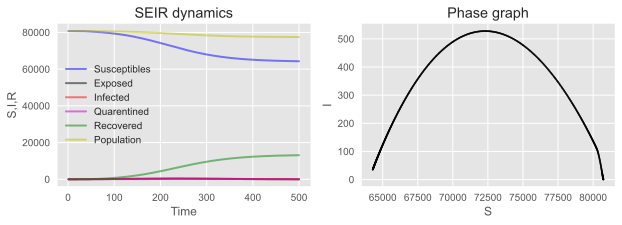

In [303]:
# Furthermore we can see that the qurantine significantly flattents the curve provinf to be an effective measure 
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(10,3))

ax = axs[0]
ax.set_title('SEIR dynamics')

ax.plot(t, S, 'b', alpha=0.5, lw=2, label= 'Susceptibles')
ax.plot(t, E, 'black', alpha=0.5, lw=2, label= 'Exposed')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label= 'Infected')
ax.plot(t, Q, 'm', alpha=0.5, lw=2, label= 'Quarentined')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label= 'Recovered')
ax.plot(t, (S + I + R + Q +E), 'y', alpha=0.5, lw=2, label= 'Population')

ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(S, I ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

<ipython-input-276-3bfe99577abb>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(beta)


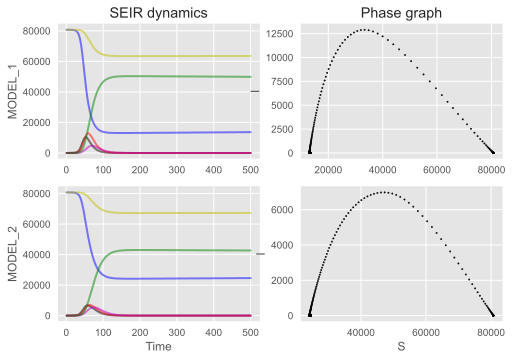

In [299]:
# Lest compare two different levels of quarentine to better visualize its effect 
C_R0_1 = 9

# compraring lower and higher lever of quarentined infected people
q1 = 0.04 
q2 = 0.08

RES1 = odeint(SEIQR_eq, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, C_R0_1, q1))
RES2 = odeint(SEIQR_eq, INPUT ,t, args=(n, m, l_beta2, g, l, death_per_group, mortality_by_group, omega, C_R0_1, q2))

S_1, E_1, I_1, Q_1, R_1 = RES1[:,:16].sum(axis=1), RES1[:,16:32].sum(axis=1), RES1[:,32:48].sum(axis=1), RES1[:,48:64].sum(axis=1), RES1[:,64:].sum(axis=1)
S_2, E_2, I_2, Q_2, R_2 = RES2[:,:16].sum(axis=1), RES2[:,16:32].sum(axis=1), RES2[:,32:48].sum(axis=1), RES2[:,48:64].sum(axis=1), RES2[:,64:].sum(axis=1)

S = np.hstack((S_1, S_2)).reshape(2,-1)
E = np.hstack((E_1, E_2)).reshape(2,-1)
I = np.hstack((I_1, I_2)).reshape(2,-1)
Q = np.hstack((Q_1, Q_2)).reshape(2,-1)
R = np.hstack((R_1, R_2)).reshape(2,-1)

fig, ax = plt.subplots(2,2, facecolor='w')

for i in range(2):        
    ax[0,0].set_title('SEIR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, E[i,:], 'black', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, Q[i,:], 'm', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R + E  + Q)[i,:], 'y', alpha=0.5, lw=2)

    ax[1,0].set_xlabel('Time')
    ax[i,0].set_ylabel('MODEL_{}'.format(i+1))

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[1,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

In [289]:
# As we can see the better qurantine is implemented the lower is the total of infected but also the flatter is the curve allowing medical professionals to deal with the virus

In [290]:
# Finally we compare the full SEIQR model with lockdown among age groups


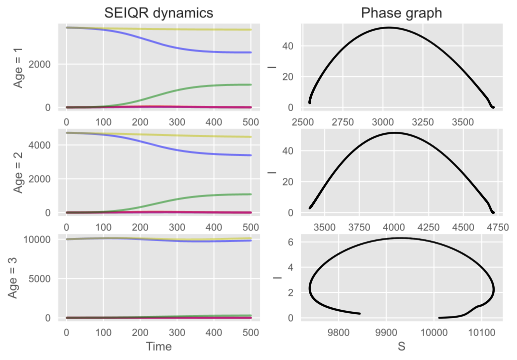

In [291]:
S_y, E_y, I_y, Q_y, R_y = RES[:,1], RES[:,17], RES[:,33], RES[:,49], RES[:,65]
S_m, E_m, I_m, Q_m, R_m = RES[:,7], RES[:,23], RES[:,39], RES[:,55], RES[:,71]
S_o, E_o, I_o, Q_o, R_o = RES[:,15], RES[:,31], RES[:,47], RES[:,61], RES[:,77]

S = np.hstack((S_y, S_m, S_o)).reshape(3,-1)
E = np.hstack((E_y, E_m, E_o)).reshape(3,-1)
I = np.hstack((I_y, I_m, I_o)).reshape(3,-1)
Q = np.hstack((Q_y, Q_m, Q_o)).reshape(3,-1)
R = np.hstack((R_y, R_m, R_o)).reshape(3,-1)

fig, ax = plt.subplots(3,2, facecolor='w')

for i in range(3):        
    ax[0,0].set_title('SEIQR dynamics')

    ax[i,0].plot(t, S[i,:], 'b', alpha=0.5, lw=2)
    ax[i,0].plot(t, E[i,:], 'black', alpha=0.5, lw=2)
    ax[i,0].plot(t, I[i,:], 'r', alpha=0.5, lw=2)
    ax[i,0].plot(t, Q[i,:], 'm', alpha=0.5, lw=2)
    ax[i,0].plot(t, R[i,:], 'g', alpha=0.5, lw=2)
    ax[i,0].plot(t, (S + I + R + E  + Q)[i,:], 'y', alpha=0.5, lw=2)

    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('Age = {}'.format(i+1))

    for spine in ('top', 'right'): 
        ax[i,0].spines[spine].set_visible(False)

    ax[0,1].set_title('Phase graph')
    ax[i,1].scatter(S[i,:], I[i,:] ,s=2, facecolor='k')

    ax[i,1].set_xlabel('S')
    ax[i,1].set_ylabel('I')

    for spine in ('top', 'right'): 
        ax[i,1].spines[spine].set_visible(False)

In [292]:
# As we can see the implementation of measures is very effective especially in the most risk prone group
# when we turn our attention to group 3 representing old people above 75+ we can see that the big drop in population is mitigated 
# by limiting the number of infctions 

# The unuasual phase graph can be explained by the fact that the 75+ age group is a larger bucket therefore when the risk of covid is not present their population slightly fluctuates up and down 